In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(400)
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns

/Users/SaswatiS/opt/anaconda3/envs/paylocity_lms/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/SaswatiS/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df=pd.read_csv('ticketmaster.csv')
print(df.shape)
df.head()

(9964, 15)


,line_num,title,createdTime,status,priority,extId,user.identity.name,user.identity.displayName,user.emailId,user.department,extId.1,integrationId,user.identity.name.1,user.identity.displayName.1,user.emailId.1
0,0.0,Scan my computer now,1.574306e+09,Closed,High,stuart.thomson@acme.com,Stuart Thomson,Stuart Thomson,stuart.thomson@acme.com,HR,gearldine_gellinger@gellinger.com,1.0,Gearldine,Gearldine Gellinger,gearldine_gellinger@gellinger.com
1,1.0,how to find address book,1.579539e+09,Closed,Low,peter.macron@acme.com,Peter Macron,Peter Macron,peter.macron@acme.com,Engineering,lnewville@newville.com,1.0,Lenna,Lenna Newville,lnewville@newville.com
2,2.0,Solution 2,1.577330e+09,Closed,Medium,victoria.lewis@acme.com,Victoria Lewis,Victoria Lewis,victoria.lewis@acme.com,Legal,virgina_tegarden@tegarden.com,1.0,Virgina,Virgina Tegarden,virgina_tegarden@tegarden.com
3,3.0,real time scanning wont turn on,1.575271e+09,Closed,Low,vincent.lee@acme.com,Vincent Lee,Vincent Lee,vincent.lee@acme.com,Culture,tfrankel@aol.com,1.0,Tiera,Tiera Frankel,tfrankel@aol.com
4,4.0,Refund,1.588172e+09,Closed,Low,kim.anderson@acme.com,Kim Anderson,Kim Anderson,kim.anderson@acme.com,Product & Services,norah.waymire@gmail.com,1.0,Norah,Norah Waymire,norah.waymire@gmail.com


In [3]:
df['title'].isna().any()

True

In [4]:
#Our primary column to work with is Title, therefore only consider non-empty data

df = df[df['title'].notna()]
df.shape

(5000, 15)

### Exploration

In [5]:
df['user.department'].unique()

array(['HR', 'Engineering', 'Legal', 'Culture', 'Product & Services',
       'DevOps', '000,false,false,Lebanon,LB,33.83333,35.83333,33.83333',
       'Altercations', 'Travel', 'Casual', 'Daily Activities',
       'Sports & Activities', 'IT & Infrastructure',
       '000,false,true,Kingdom of Norway,NO,62,10,62.0',
       '000,false,true,Republic of the Congo,CG,-1,15.5,-1.0',
       '000,false,true,Republic of Panama,PA,9,-80,9.0',
       '000,false,false,Argentine Republic,AR,-34,-64,-34.0', 'Customers',
       '000,false,true,Islamic Republic of Afghanistan,AF,33,66,33.0',
       '000,false,true,Co-operative Republic of Guyana,GY,5,-59,5.0',
       '000,false,false,Republic of Kazakhstan,KZ,48,68,48.0',
       '000,false,true,Hashemite Kingdom of Jordan,JO,31,36,31.0',
       'Conferences', '000,false,true,Kingdom of Morocco,MA,32,-6,32.0',
       '000,false,false,Bosnia and Herzegovina,BA,44.25,17.83333,44.25',
       '000,false,false,State of Kuwait,KW,29.5,47.75,29.5',
       '00

In [6]:
#Label the inconsistent values as Bad data and analyze it separately

dept=['HR', 'Engineering', 'Legal', 'Culture', 'Product & Services',
       'DevOps','Altercations', 'Travel', 'Casual', 'Daily Activities',
       'Sports & Activities', 'IT & Infrastructure']

df['user.department']= np.where(df['user.department'].isin(dept),df['user.department'],"bad_data")

<AxesSubplot:xlabel='count', ylabel='user.department'>

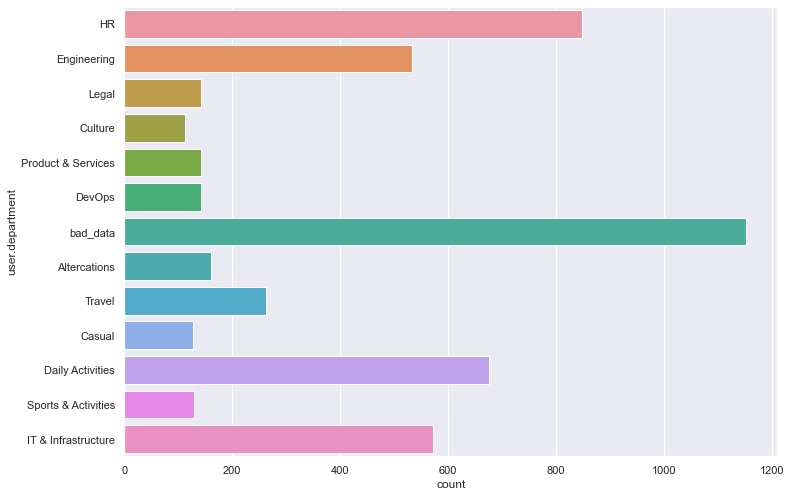

In [7]:
# The plot below shows the department and the # of tickets that gets generated from the department

sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.countplot(ax=ax, y="user.department", data=df)

Bad data Department label shows the maximum ticket generation.(Understand what thode location data means)

Top department generating tickets: HR, Daily activity, IT & Infrastructure, and Engineering

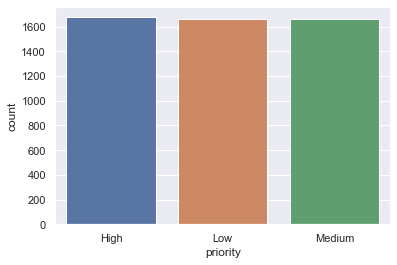

In [8]:
#Frequency plot based on Ticket priority

sns.set_theme(style="darkgrid")
ax = sns.countplot(x="priority", data=df)

Seems like there is an almost equal distribution of High, Medium and Low ticket

In [9]:
#Generate a word cloud to see what most tickets describes

words_=df['title'].str.cat()
#clean
words_ = re.sub(r'==.*?==+', '', words_)
words_ = words_.replace('\n', '')

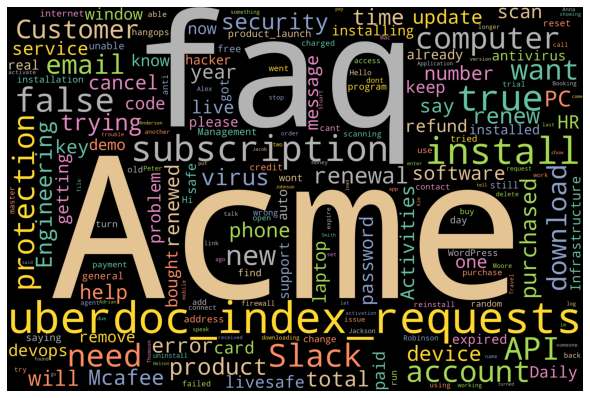

In [10]:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black',\
                      colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(words_)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Analyze some of the high frequency words from the word cloud

### LDA Topic Modeling

In [11]:
#pre processing func

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [12]:
#Preprocess

processed_tickets = []

for ticket in df['title']:
    processed_tickets.append(preprocess(ticket))

print(processed_tickets[:2])

[['scan'], ['address', 'book']]


In [13]:
dict_a = gensim.corpora.Dictionary(processed_tickets)

count = 0
for k, v in dict_a.iteritems():
    print(k,v)
    count += 1
    if count > 5:
        break

0 scan
1 address
2 book
3 solut
4 real
5 time


In [14]:
dict_a.filter_extremes(no_below=5, no_above=0.1, keep_n= 1000)

In [15]:
#Bag-of-words model for each ticket i.e for each ticket we create a dictionary reporting word and frequency

bow_corpus = [dict_a.doc2bow(ticket) for ticket in processed_tickets]

In [16]:
#BOW for our sample preprocessed document

ticket_num = 20
bow_ticket_x = bow_corpus[ticket_num]

for i in range(len(bow_ticket_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_ticket_x[i][0], 
                                                     dict_a[bow_ticket_x[i][0]], 
                                                     bow_ticket_x[i][1]))

Word 52 ("agent") appears 1 time.


In [17]:
# LDA multicore 

lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 6, 
                                   id2word = dict_a,                                    
                                   passes = 10)

In [18]:
# For each topic, we will explore the words occuring in that topic and its relative weight

for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.063*"true" + 0.049*"slack" + 0.047*"fals" + 0.035*"custom" + 0.026*"grzg" + 0.021*"product" + 0.019*"activ" + 0.019*"engin" + 0.015*"servic" + 0.014*"antiviru"


Topic: 1 
Words: 0.075*"protect" + 0.040*"updat" + 0.032*"purchas" + 0.031*"total" + 0.030*"need" + 0.030*"livesaf" + 0.025*"refund" + 0.023*"get" + 0.022*"window" + 0.018*"pay"


Topic: 2 
Words: 0.096*"renew" + 0.090*"subscript" + 0.045*"live" + 0.041*"cancel" + 0.038*"error" + 0.036*"agent" + 0.030*"code" + 0.028*"want" + 0.023*"work" + 0.021*"problem"


Topic: 3 
Words: 0.088*"account" + 0.048*"email" + 0.036*"fals" + 0.025*"address" + 0.021*"year" + 0.019*"slack" + 0.018*"engin" + 0.018*"subscript" + 0.015*"activ" + 0.013*"want"


Topic: 4 
Words: 0.072*"password" + 0.058*"download" + 0.038*"secur" + 0.035*"reset" + 0.025*"true" + 0.024*"uninstal" + 0.023*"have" + 0.022*"chang" + 0.021*"program" + 0.021*"need"


Topic: 5 
Words: 0.047*"scan" + 0.047*"viru" + 0.037*"number" + 0.033*"mcafe" + 0.032*"remov

#### interpret the topics

Application error: 2
Need Help Understanding: 1,5
New Feature Request: 0,3
Terminate Service: 4

In [19]:
#Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.



Perplexity:  -5.738209910931594


In [20]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each ticket
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    return(sent_topics_df)


In [21]:

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=processed_tickets)



In [22]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Ticket_no', 'Dominant_Topic', 'Perc_Contrib', 'Keywords', 'Text']

# Show
print(df_dominant_topic.shape)
df_dominant_topic.head(10)

(5000, 5)


,Ticket_no,Dominant_Topic,Perc_Contrib,Keywords,Text
0,0,5.0,0.5832,"scan, viru, number, mcafe, remov, time, help, ...",[scan]
1,1,3.0,0.7218,"account, email, fals, address, year, slack, en...","[address, book]"
2,2,0.0,0.5830,"true, slack, fals, custom, grzg, product, acti...",[solut]
3,3,5.0,0.8609,"scan, viru, number, mcafe, remov, time, help, ...","[real, time, scan, wont, turn]"
4,4,1.0,0.5824,"protect, updat, purchas, total, need, livesaf,...",[refund]
5,5,5.0,0.3903,"scan, viru, number, mcafe, remov, time, help, ...","[number, custom, suport]"
6,6,1.0,0.5830,"protect, updat, purchas, total, need, livesaf,...","[updat, acm]"
7,7,4.0,0.7911,"password, download, secur, reset, true, uninst...","[reset, true, password]"
8,8,5.0,0.7221,"scan, viru, number, mcafe, remov, time, help, ...","[turn, wall]"
9,9,0.0,0.8646,"true, slack, fals, custom, grzg, product, acti...","[tell, trojan, scan, day, custom, proof, conce..."


In [23]:
df_dominant_topic.dtypes

Ticket_no           int64
Dominant_Topic    float64
Perc_Contrib      float64
Keywords           object
Text               object
dtype: object

In [24]:

# Application error: 0,2
# Need Help Understanding: 1,5
# New Feature Request: 4
# Terminate Service: 3

In [25]:
#Interpret the topics and join it to the dataset

app_err=[2.0]
need_help=[1.0,5.0]
new_feature=[0.0,3.0]
terminate_service=[4.0]

df_dominant_topic['Sentiment_category']=np.where(df_dominant_topic['Dominant_Topic'].isin(app_err),'Application Error',\
         np.where(df_dominant_topic['Dominant_Topic'].isin(need_help),'Need Help Understanding',\
                  np.where(df_dominant_topic['Dominant_Topic'].isin(new_feature),'New Feature Request',\
                           np.where(df_dominant_topic['Dominant_Topic'].isin(terminate_service),'Terminate Service',\
                                   'None'
                                   )
                          )
                 )
        )
        

In [26]:
df_dominant_topic.head()

,Ticket_no,Dominant_Topic,Perc_Contrib,Keywords,Text,Sentiment_category
0,0,5.0,0.5832,"scan, viru, number, mcafe, remov, time, help, ...",[scan],Need Help Understanding
1,1,3.0,0.7218,"account, email, fals, address, year, slack, en...","[address, book]",New Feature Request
2,2,0.0,0.5830,"true, slack, fals, custom, grzg, product, acti...",[solut],New Feature Request
3,3,5.0,0.8609,"scan, viru, number, mcafe, remov, time, help, ...","[real, time, scan, wont, turn]",Need Help Understanding
4,4,1.0,0.5824,"protect, updat, purchas, total, need, livesaf,...",[refund],Need Help Understanding


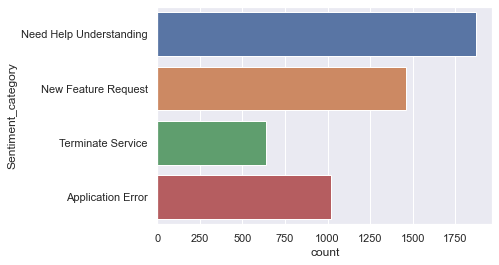

In [27]:
#Frequency plot based on Ticket priority

sns.set_theme(style="darkgrid")
ax = sns.countplot(y="Sentiment_category", data=df_dominant_topic)

#### After associating the text with different sentiment category, we can see the volume of tickets we recieve from each category

In [28]:
df_final=df.merge(df_dominant_topic, left_index=True, right_index=True)
print(df_final.shape)

(5000, 21)


<AxesSubplot:xlabel='count', ylabel='user.department'>

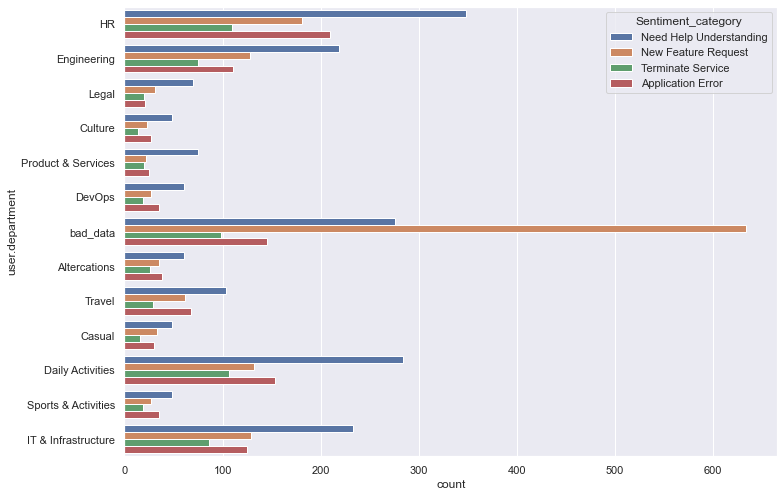

In [33]:
#Frequency plot based on Ticket priority

sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.countplot(ax=ax, y="user.department", hue="Sentiment_category", data=df_final)

In [29]:
drop_cols=['Ticket_no','Dominant_Topic','Perc_Contrib','Keywords','Text']
df_final.drop(drop_cols,axis=1,inplace=True)

In [30]:
df_final.to_csv('Output_category.csv')